In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
%pip install keras numpy pandas scikit-learn matplotlib seaborn tensorflow


  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached numpy-1.26.2-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached pandas-2.1.3-cp312-cp312-win_amd64.whl.metadata (18 kB)
  Using cached scikit_learn-1.3.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.8.2-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [5]:
# endpoint = 'df_jepx_spotsum.csv'
# res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=1000')
# hist = pd.DataFrame(json.loads(res.content)['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# target_col = 'close'

In [23]:
jepx = pd.read_csv("df_jepx_spotsum.csv", parse_dates=['DATETIME'], usecols=[0,7])
jepx = jepx.set_index('DATETIME')
jepx.index = pd.to_datetime(jepx.index, unit='s')
target_col = 'SYSTEM_PRICE'

In [24]:
jepx.head(5)

,SYSTEM_PRICE
DATETIME,
2005-04-02 00:00:00,6.71
2005-04-02 00:30:00,6.65
2005-04-02 01:00:00,6.39
2005-04-02 01:30:00,6.39
2005-04-02 02:00:00,5.68


In [25]:
jepx.describe()

,SYSTEM_PRICE
count,325824.000000
mean,11.286967
std,7.911367
min,0.010000
25%,7.120000
50%,9.680000
75%,13.790000
max,251.000000


In [ ]:
# hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [27]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [28]:
train, test = train_test_split(jepx, test_size=0.3)

In [29]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('SYSTEM_PRICE', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

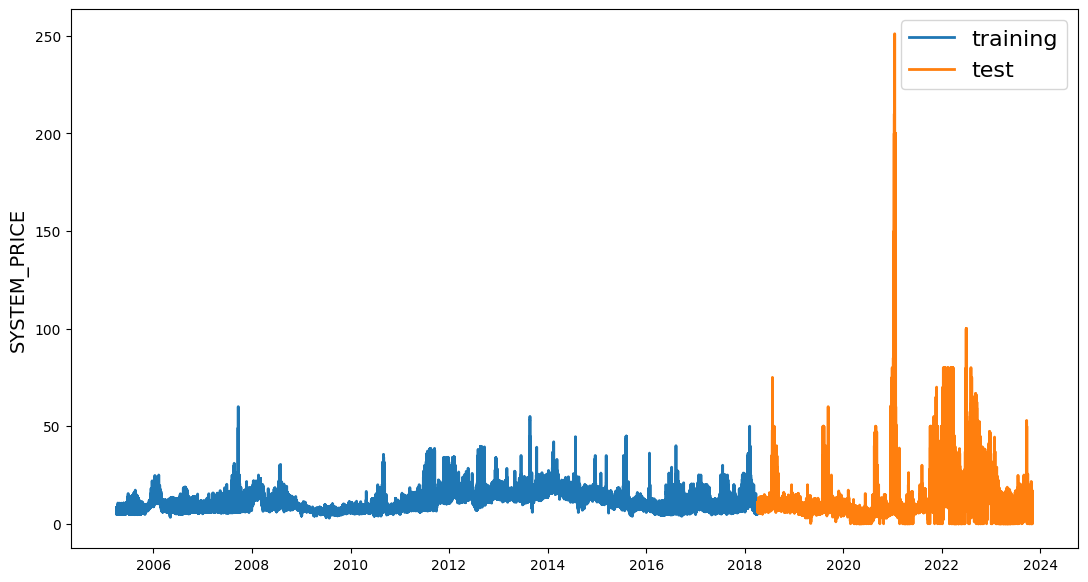

In [30]:
#@title
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [31]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [32]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [33]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [35]:
prepare_data(jepx,target_col)

(                     SYSTEM_PRICE
 DATETIME                         
 2005-04-02 00:00:00          6.71
 2005-04-02 00:30:00          6.65
 2005-04-02 01:00:00          6.39
 2005-04-02 01:30:00          6.39
 2005-04-02 02:00:00          5.68
 ...                           ...
 2020-02-13 07:30:00          8.01
 2020-02-13 08:00:00          7.85
 2020-02-13 08:30:00          8.89
 2020-02-13 09:00:00          8.98
 2020-02-13 09:30:00          8.08
 
 [260660 rows x 1 columns],
                      SYSTEM_PRICE
 DATETIME                         
 2020-02-13 10:00:00          7.53
 2020-02-13 10:30:00          6.57
 2020-02-13 11:00:00          5.99
 2020-02-13 11:30:00          5.32
 2020-02-13 12:00:00          5.32
 ...                           ...
 2023-11-01 21:30:00         13.91
 2023-11-01 22:00:00         13.14
 2023-11-01 22:30:00         12.75
 2023-11-01 23:00:00         12.60
 2023-11-01 23:30:00         11.69
 
 [65164 rows x 1 columns],
 array([[[ 0.        ],
       

In [36]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [37]:
np.random.seed(5)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 10
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [38]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
jepx, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [39]:
jepx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325824 entries, 2005-04-02 00:00:00 to 2023-11-01 23:30:00
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SYSTEM_PRICE  325824 non-null  float64
dtypes: float64(1)
memory usage: 5.0 MB


In [40]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
8146/8146 [==============================] - 46s 5ms/step - loss: 0.0100 - val_loss: 12734.7188
Epoch 2/20
8146/8146 [==============================] - 42s 5ms/step - loss: 0.0081 - val_loss: 12719.6387
Epoch 3/20
8146/8146 [==============================] - 39s 5ms/step - loss: 0.0080 - val_loss: 12726.2598
Epoch 4/20
8146/8146 [==============================] - 40s 5ms/step - loss: 0.0080 - val_loss: 12730.6719
Epoch 5/20
8146/8146 [==============================] - 41s 5ms/step - loss: 0.0080 - val_loss: 12738.3398
Epoch 6/20
8146/8146 [==============================] - 40s 5ms/step - loss: 0.0079 - val_loss: 12728.7314
Epoch 7/20
8146/8146 [==============================] - 39s 5ms/step - loss: 0.0080 - val_loss: 12718.5430
Epoch 8/20
8146/8146 [==============================] - 42s 5ms/step - loss: 0.0079 - val_loss: 12715.9482
Epoch 9/20
8146/8146 [==============================] - 42s 5ms/step - loss: 0.0080 - val_loss: 12714.3105
Epoch 10/20
8146/8146 [==============

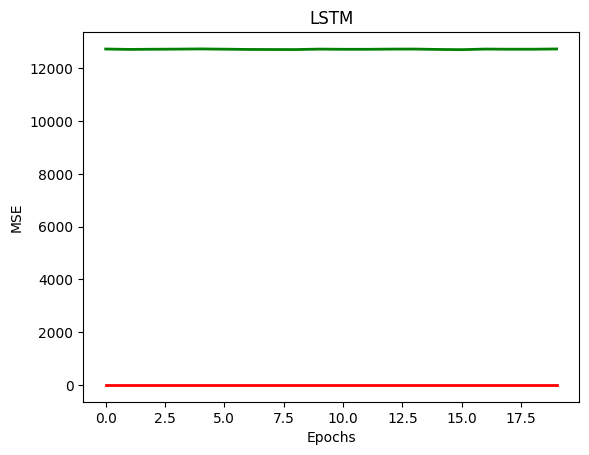

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [42]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

2037/2037 [==============================] - 5s 2ms/step


11.153203827330804

In [43]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

12736.627991935055

In [44]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

-0.005170390362583266

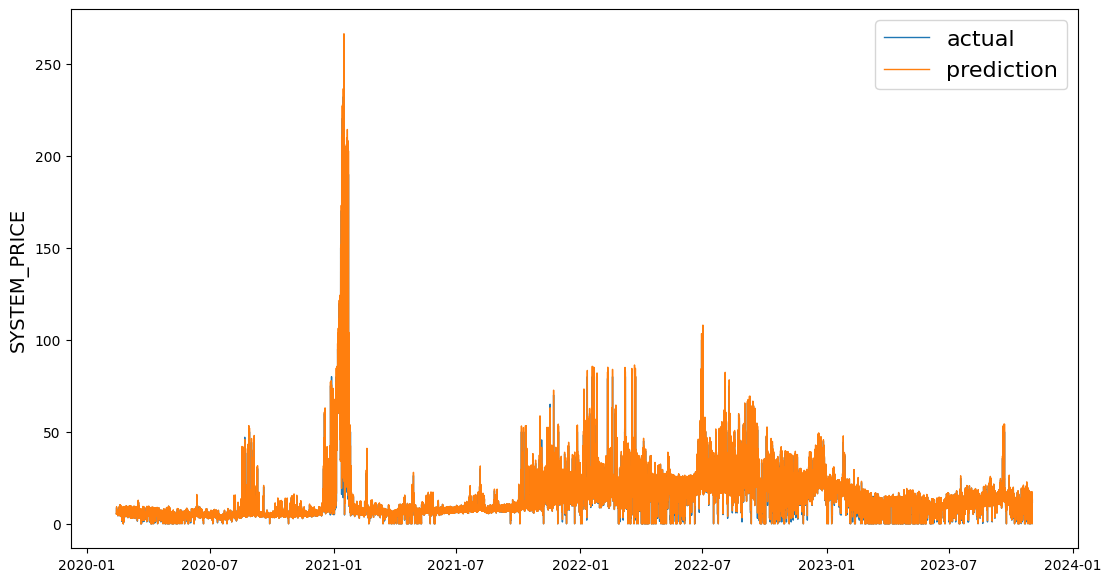

In [45]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=1)